In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import time

In [3]:
#from tensorflow.keras import models
#from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [34]:
df_input = pd.read_csv("CD_OA_std", usecols=[1,2,3,4])

In [35]:
df_output = pd. read_csv("CD_OA", usecols=[8])
#df_output=df_output*0.0001 #A/m^2からA/cm^2へ変換 ←これで学習させたら性能出なかった
#df_output

In [36]:
df_input.shape

(351, 4)

In [37]:
df_output.shape

(351, 1)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.1, random_state=0)

In [39]:
print(x_train.shape,x_test.shape)

(315, 4) (36, 4)


In [40]:
x_train

,V_cell,P_b,T_cell,stoichi_anode
76,-1.336306,0.000040,-1.224745e+00,0.000000
198,0.801784,0.000040,-1.392374e-14,1.224745
171,1.069045,-1.224765,-1.392374e-14,0.000000
20,-0.267261,-1.224765,-1.392374e-14,0.000000
281,-0.534522,1.224725,1.224745e+00,0.000000
...,...,...,...,...
323,-1.336306,-1.224765,-1.224745e+00,-1.224745
192,-1.069045,-1.224765,1.224745e+00,1.224745
117,1.603567,1.224725,1.224745e+00,0.000000
47,-0.534522,0.000040,-1.392374e-14,1.224745


In [41]:
y_train

,i_ave
76,6357.860611
198,659.208170
171,187.579905
20,2998.328011
281,5424.794499
...,...
323,5403.622146
192,3090.050343
117,91.491481
47,4334.846625


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers, initializers

model = Sequential()

weights = [com.get_weights() for com in model.layers[0:]]  #重さを抽出（※始めに回すときだけ下の行と入れ替える）



model.add(Dense(units=32, input_shape=(4,), activation='relu'))  
model.add(Dense(units=10, activation='relu'))  #
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='linear'))  #隠れ層3層でやってみる

model.compile(loss='mean_absolute_error',    
              optimizer='adam',             #とりあえずadamで
              metrics=['mae'],
              run_eagerly=False)   #計算時間5倍くらいかかる

In [43]:
start_time = time.time()
callbacks1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae',
                            factor=0.2,
                            patience=5,
                            mode="auto",
                            min_lr=1e-2)
callbacks2 = tf.keras.callbacks.EarlyStopping(monitor="val_mae",
                                              patience=50,
                                              mode="auto")
history =  model.fit(x=x_train,
                     y=y_train,
                     epochs = 20000,
                     batch_size=200,
                     validation_data=(x_test, y_test),
                     callbacks=[callbacks1,callbacks2])
end_time = time.time()
elapsed_time = end_time - start_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

Epoch 1/20000


2/2 [==============================] - 1s 203ms/step - loss: 3073.3167 - mae: 3073.3167 - val_loss: 3350.8281 - val_mae: 3350.8281 - lr: 0.0010
Epoch 2/20000
2/2 [==============================] - 0s 46ms/step - loss: 3073.2742 - mae: 3073.2742 - val_loss: 3350.7874 - val_mae: 3350.7874 - lr: 0.0010
Epoch 3/20000
2/2 [==============================] - 0s 33ms/step - loss: 3073.2336 - mae: 3073.2336 - val_loss: 3350.7468 - val_mae: 3350.7468 - lr: 0.0010
Epoch 4/20000
2/2 [==============================] - 0s 33ms/step - loss: 3073.1934 - mae: 3073.1934 - val_loss: 3350.7061 - val_mae: 3350.7061 - lr: 0.0010
Epoch 5/20000
2/2 [==============================] - 0s 30ms/step - loss: 3073.1528 - mae: 3073.1528 - val_loss: 3350.6650 - val_mae: 3350.6650 - lr: 0.0010
Epoch 6/20000
2/2 [==============================] - 0s 32ms/step - loss: 3073.1118 - mae: 3073.1118 - val_loss: 3350.6240 - val_mae: 3350.6240 - lr: 0.0010
Epoch 7/20000
2/2 [==============================] - 0s 32ms/step - los

In [44]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

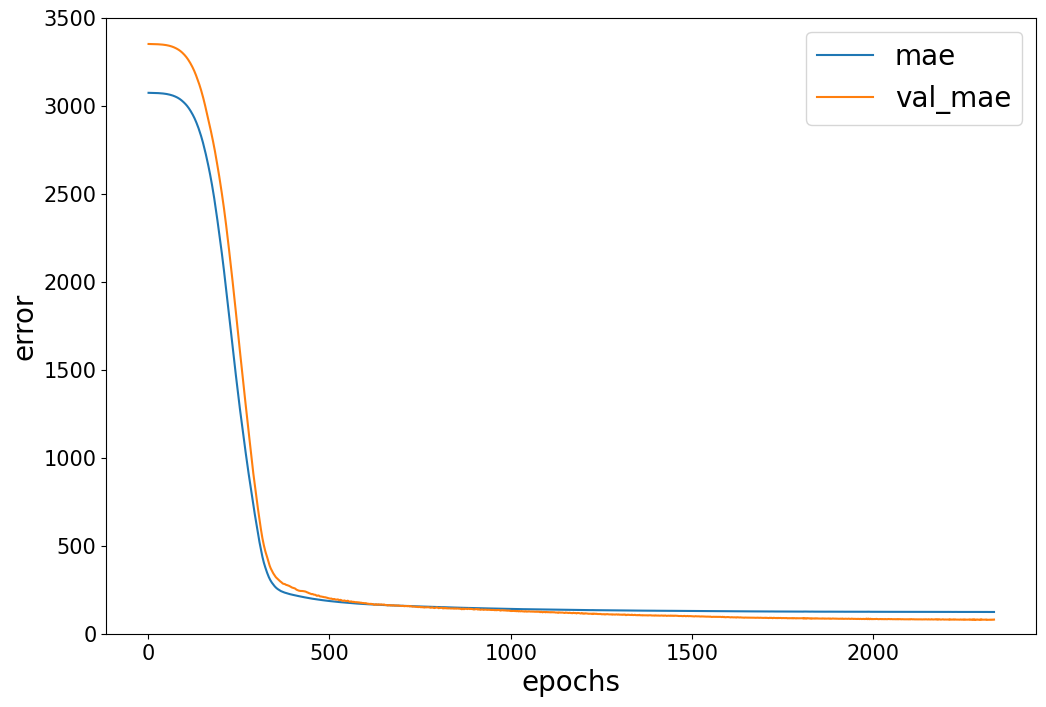

In [45]:
mae = history_dict['mae']
val_mse = history_dict['val_mae']
epochs = range(1, len(mae) + 1)

plt.rcParams["font.size"] = 15
plt.figure(figsize=(12, 8))
plt.plot(epochs, mae, label='mae')
plt.plot(epochs, val_mse, label='val_mae')
plt.xlabel("epochs",fontsize=20)
plt.ylabel("error",fontsize=20)
plt.ylim((0,3500))
plt.legend(loc = 'best',fontsize=20)
#plt.savefig('mae_transition.png')
plt.show()

In [46]:
import tensorflow as tf

# MAPEを計算する関数を定義
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10  # ゼロで割ることを避けるための小さな値
    percentage_error = tf.abs((y_true - y_pred) / (tf.maximum(tf.abs(y_true), epsilon)))
    mape = tf.reduce_mean(percentage_error) * 100.0
    return mape

df7 = model.predict(df_input)
# MAPEを計算
df7 = pd.DataFrame(df7)
df8 = pd.concat([pd.DataFrame(df_output),df7], axis=1)

y_true = tf.constant(df8.iloc[:, 0].values, dtype=tf.float32)
y_pred = tf.constant(df8.iloc[:, 1].values, dtype=tf.float32)
mape_value = mean_absolute_percentage_error(y_true,y_pred)

# 結果を表示
print(f"MAPE: {mape_value.numpy()}%")

11/11 [==============================] - 0s 3ms/step
MAPE: 7.198660850524902%


In [47]:
weights = [com.get_weights() for com in model.layers[0:]] 
model.layers[0].set_weights(weights[0])
model.layers[1].set_weights(weights[1])
model.layers[2].set_weights(weights[2])

In [48]:
model.save('i_predict CD_OA2')

INFO:tensorflow:Assets written to: i_predict CD_OA2\assets
